In [3]:
import methods.model as model
import methods.dists as dists
import methods.execution as execution

import os 
import sys
import numpy as np
import time


# 1. How to setup a batch
### Let's start from the batch simulator (you can find it in the main.py file as well)

### This cell defines constants and default values used throughout the simulation


In [4]:
rng = np.random.default_rng(seed=42) #! this doesn't work completely as expected, do not mind

SIZE_SCALE = 1  # Scale factor for the number of agents
LENGTH_SCALE = 6  # Scale factor for the number of transactions
MEAN_IET = 43706315  # Actually, total time in seconds, not IET. 43706315 seconds =  1 Sarafu time unit (About 1 yr and a half)

N = 25_000 // SIZE_SCALE  # Number of agents
T = int(500_000 * LENGTH_SCALE)  # Total number of transactions. 500_00 is about the number we have in sarafu dataset (a bit more)
D = T / MEAN_IET  # Number of days (currently unused)
saved = 500_000  # Number of iterations to save

### Enable Test Mode for Quick Debugging

This section prompts the user to choose whether to run the simulation in test mode.
If test mode is selected, smaller values are used for faster iteration and debugging.


In [5]:
test = input('Is this a test? (y/n)')

if test == 'y':
    N = 500
    T = 50
    saved = 20

print(f"Iteration : {T:_}")
print(f"Save : {saved:_}")

Iteration : 50
Save : 20


### Define All Distributions for Agent Behavior

In this step, we define all key statistical behaviors for agents using named distributions:

- **Spending Rate**: Probability of spending per agent.
- **Initial Balance**: Starting funds for each agent.
- **Activity**: Likelihood to initiate a transaction.
- **Attractivity**: Likelihood to be selected as a recipient.
- **Copula**: Joint distribution capturing dependency between activity and attractivity.

Each is represented by:
- A name
- Parameters
- A lambda function for value generation


In [6]:
# Spending rate distribution
spending_rate_list = [
    ("uniform", [0, 1], lambda N: rng.uniform(1e-16, 1, N)),
    # ("beta", [0.4, 0.6], lambda N: rng.beta(0.4, 0.6, N)),
]

# Initial balances
initial_bal_list = [
    ("constant", [1000], lambda N: 1000 * np.ones(N)),
    # ("uniform", [0, 2000], lambda N: rng.uniform(1e-16, 2000, N)),
]

# Activity distribution
activity_distributions = [
    ("powlaw", [1.85, 1, 1838], lambda unif: dists.powlaw_ppf(1.85, 1, 1838)(unif)),
]

# Attractivity distribution
attractivity_distributions = [
    ("powlaw", [1.87, 1, 2118], lambda unif: dists.powlaw_ppf(1.87, 1, 2118)(unif)),
]

# Copula for joint distribution of activity and attractivity
copulas = [
    ('joe', 3.15, False),
    # ('joe', 1, False),
]


### Define the remaining parameters

We use lists, always. When we use the same value over all the simulations we use a single valued list

In [7]:
betabinomial_s = [1, 2, 3, 5, 10]  # Scale parameters for beta-binomial behavior
burstiness = [0.25, 1]             # Temporal clustering of activity
decimals = [3]                     # Decimal precision for numerical values


### Define the Simulation Parameter Grid

Here, we organize all simulation parameters into a dictionary. Each key maps to a list of values that will be used to create all combinations of parameter settings.

This parameter grid drives the batch simulations by specifying:
- Agent and environment properties
- Behavioral distribution types
- Simulation scales and precision


In [8]:
parameter_dict = {
    "s": betabinomial_s,  # List of scaling values (always use list)
    "spending_rate": spending_rate_list,
    "initial_balance": initial_bal_list,
    "decimals": decimals, # Decimal precision for balances
    "copula": copulas,
    "activity_distribution": activity_distributions,
    "attractivity_distribution": attractivity_distributions,
    "N": [N],  # Number of agents
    "T": [T],  # Total time steps
    "D": [D],  # Derived value (optional use)
    "SIZE_SCALE": [SIZE_SCALE],
    "LENGTH_SCALE": [LENGTH_SCALE],
    "MEAN_IET": [MEAN_IET],
    "burstiness": burstiness,  # Activity burst levels
}


### Create Output Directory

This step sets the output directory based on whether test mode is enabled. It ensures the directory exists before running simulations.

If not in test mode, the script pauses for confirmation to avoid accidental writes.


In [9]:
continue_running = 'y'  # Automatically proceed (no prompt)

if continue_running == 'n':
    print('Please create the output directory')
    exit()

# Choose output path based on test mode
output_dir = (
    "files/new_version/000/test"
    if test == 'y'
    else "files/new_version/000"
)

if test != 'y':
    print(output_dir)
    input('Continue?')  # Pause for confirmation in full run mode

# Ensure the directory exists
os.makedirs(output_dir, exist_ok=True)


### Generate Parameter Grid and Run Simulations

In this final step:

1. We generate all combinations of the parameter settings using `create_parameter_grid`.
2. We pass this grid to the batch runner along with:
   - The number of transactions to save.
   - The output directory path.

This will launch the full set of simulations using the specified agent behaviors and environment settings.


Batch Simulations:   0%|          | 0/10 [00:00<?, ?it/s]

Batch Simulations:  10%|█         | 1/10 [00:00<00:01,  8.34it/s]

Completed simulation: {'s': 1, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x7fa7de05acb0>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25}
Execution time: 0.06 seconds
End of 0: 216.32 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 1, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', 

Batch Simulations:  30%|███       | 3/10 [00:00<00:00,  9.61it/s]

Memory cleared.
Completed simulation: {'s': 2, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x7fa7de05acb0>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1}
Execution time: 0.04 seconds
End of 3: 218.18 MB (Resident Set Size)


Batch Simulations:  40%|████      | 4/10 [00:00<00:00,  9.66it/s]

Memory cleared.
Completed simulation: {'s': 3, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x7fa7de05acb0>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25}
Execution time: 0.04 seconds
End of 4: 218.18 MB (Resident Set Size)
Memory cleared.


Batch Simulations:  60%|██████    | 6/10 [00:00<00:00,  9.89it/s]

Completed simulation: {'s': 3, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x7fa7de05acb0>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1}
Execution time: 0.04 seconds
End of 5: 218.18 MB (Resident Set Size)
Memory cleared.
Completed simulation: {'s': 5, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.

Batch Simulations:  80%|████████  | 8/10 [00:00<00:00, 10.06it/s]

Memory cleared.
Completed simulation: {'s': 10, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x7fa7de05acb0>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 0.25}
Execution time: 0.04 seconds
End of 8: 218.18 MB (Resident Set Size)


Batch Simulations: 100%|██████████| 10/10 [00:01<00:00,  9.88it/s]

Memory cleared.
Completed simulation: {'s': 10, 'spending_rate': ('uniform', [0, 1], <function <lambda> at 0x7fa7de05b910>), 'initial_balance': ('constant', [1000], <function <lambda> at 0x7fa7de05b6d0>), 'decimals': 3, 'copula': ('joe', 3.15, False), 'activity_distribution': ('powlaw', [1.85, 1, 1838], <function <lambda> at 0x7fa7de05b490>), 'attractivity_distribution': ('powlaw', [1.87, 1, 2118], <function <lambda> at 0x7fa7de05acb0>), 'N': 500, 'T': 50, 'D': 0.0686399665586083, 'SIZE_SCALE': 1, 'LENGTH_SCALE': 6, 'MEAN_IET': 43706315, 'burstiness': 1}
Execution time: 0.04 seconds
End of 9: 218.18 MB (Resident Set Size)
Memory cleared.


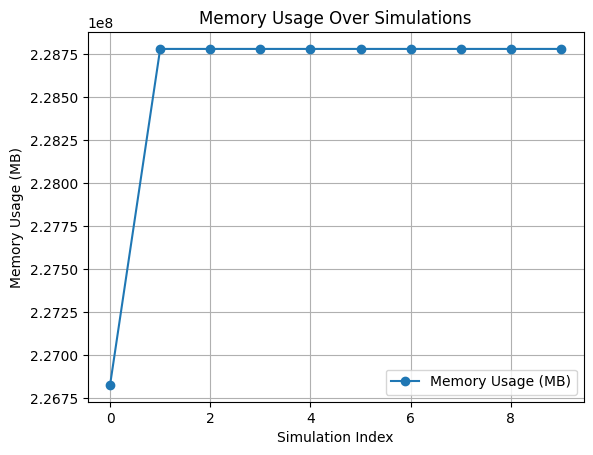

All simulations completed.
Total execution time: 1.17 seconds


<Figure size 640x480 with 0 Axes>

In [10]:
# Create all combinations of parameters
parameter_grid = execution.create_parameter_grid(parameter_dict)

# Run batch simulations using the generated grid
execution.batch_runner(parameter_grid, saved, output_dir)


# 1.a How does `batch_runner()` works?

Dedicated tutorial is in progress, the function is verbosely commented.

# 2. A single simulation

### Now let's look at how a single run works

